# Measure GRACE performance on identified objects:

### All metrics here are **exact**, i.e measure similarity between two graphs formed of identical node count which have the same positions. The only thing that differs between the graphs is the edges and object membership / individual identities. 

*Note:* The rationale behind evaluating the per-node and per-edge metrics at this stage is that the optimisation step can (and most likely will) change the identities of the individual nodes / edges when looking for a globally optimal solution. For example, a single node be predicted (by the GCN / classification method of choice) to have a high probability of being considered a real node (true positive, TP), but if such node is surrounded by no other plausible nodes or forms no acceptable edges, it has a high likelihood to be considered a fake node (true negative, TN) in favour of the global optimisation. This is why evaluation of the node- & edge-specific metrics is vital to observe the changes made to the graph components as a result of the optimisation step.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.metrics import (
    confusion_matrix, 
    precision_recall_fscore_support,
    jaccard_score,
)


In [2]:
from grace.base import GraphAttrs
from grace.models.optimiser import optimise_graph

from grace.io.image_dataset import generate_ground_truth_graph

from grace.simulator.simulate_graph import (
    random_graph, 
    update_graph_with_dummy_predictions, 
    imply_annotations_from_dummy_predictions
)

from grace.evaluation.visualisation import (
    plot_simple_graph,
    plot_connected_components
)


/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generate a random graph, update dummy labels & generate GT graph:

In [3]:
G = random_graph(n_motifs=5, density=0.05)
node_conf, edge_conf = 0.5, 0.1
update_graph_with_dummy_predictions(
    G, 
    node_confidence=node_conf, 
    edge_confidence=edge_conf
)
imply_annotations_from_dummy_predictions(G)

In [4]:
true_graph = generate_ground_truth_graph(G)
true_graph

In [5]:
# node_conf, edge_conf = 0.5, 0.3
# update_graph_with_dummy_predictions(
#     G, 
#     node_confidence=node_conf, 
#     edge_confidence=edge_conf
# )
pred_graph = optimise_graph(G)
pred_graph

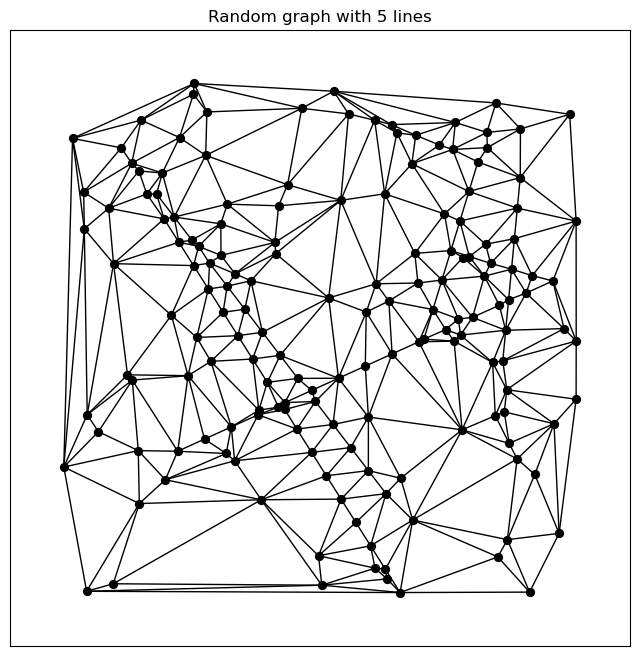

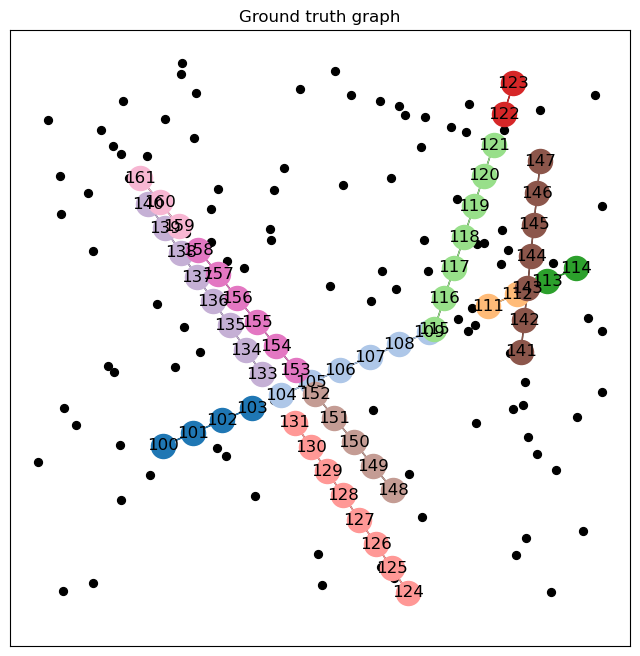

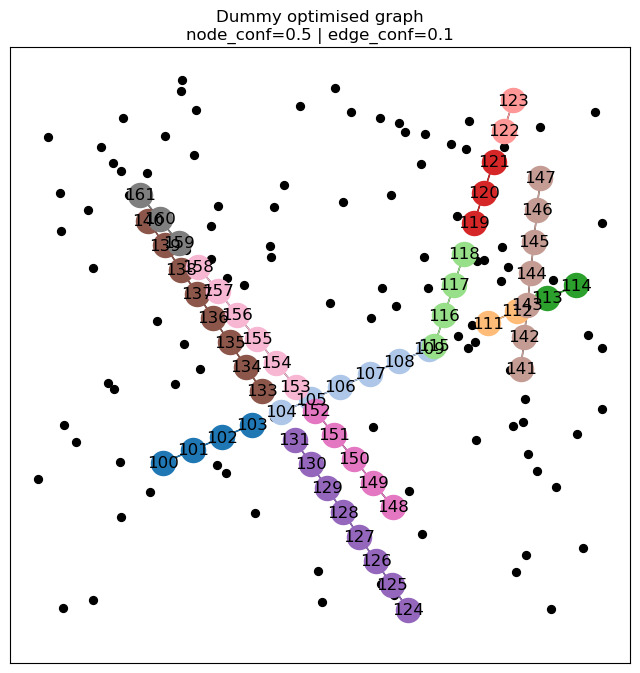

In [6]:
figsize = (8, 8)
plot_simple_graph(G, figsize=figsize, title="Random graph with 5 lines")
plot_connected_components(true_graph, figsize=figsize, title=f"Ground truth graph")
plot_connected_components(pred_graph, figsize=figsize, title=f"Dummy optimised graph\nnode_conf={node_conf} | edge_conf={edge_conf}")


### Perform checks:

In [10]:
assert pred_graph.number_of_nodes() == true_graph.number_of_nodes()
# assert pred_graph.number_of_edges() == true_graph.number_of_edges()


### simple confusion matrix?

In [11]:
def pool_connected_components_nodes(G: nx.Graph) -> set[int]:

    con_pool = set()
    cc = nx.connected_components(G)
    for comp in cc:
        # Ignore 1-node components:
        if len(comp) > 1:
            con_pool.update(comp)
    return con_pool

In [12]:
def pool_connected_components_edges(G: nx.Graph) -> set[int]:

    con_pool = set()
    cc = nx.connected_components(G)
    for comp in cc:
        if len(comp) > 1:
            for i in range(len(list(comp)) - 1):
                src, dst = list(comp)[i:i+2]
                con_pool.update([(src, dst), (dst, src)])
    return con_pool


In [13]:
con_pool_pred_nodes = pool_connected_components_nodes(pred_graph)
con_pool_pred_edges = pool_connected_components_edges(pred_graph)
con_pool_true_nodes = pool_connected_components_nodes(true_graph)
con_pool_true_edges = pool_connected_components_edges(true_graph)


In [14]:
# Iterate through node indices, check if their belonging agrees between graphs. Same for the edges:
# Pool all the connected components into a single, large set. That will be the pool to evaluate.


### Generalise the conf matrix + accuracy, precision, recall & f-score:

In [15]:
def generate_label_vector(input_data_set: set, component_pool_set: set):
    y_labels = [n in component_pool_set for n in input_data_set]
    y_labels = np.array(y_labels).astype(int)
    return y_labels

In [16]:
y_pred_nodes = generate_label_vector(input_data_set=G.nodes(data=False), component_pool_set=con_pool_pred_nodes)
y_true_nodes = generate_label_vector(input_data_set=G.nodes(data=False), component_pool_set=con_pool_true_nodes)

y_pred_edges = generate_label_vector(input_data_set=G.edges(data=False), component_pool_set=con_pool_pred_edges)
y_true_edges = generate_label_vector(input_data_set=G.edges(data=False), component_pool_set=con_pool_true_edges)


In [17]:
cm_nodes_all = confusion_matrix(y_pred=y_pred_nodes, y_true=y_true_nodes)
cm_edges_all = confusion_matrix(y_pred=y_pred_edges, y_true=y_true_edges)
cm_nodes_all, cm_edges_all

(array([[104,   0],
        [  0,  60]]),
 array([[430,   0],
        [  2,  44]]))

In [18]:
cm_nodes_nrm = confusion_matrix(y_pred=y_pred_nodes, y_true=y_true_nodes, normalize='true')
cm_edges_nrm = confusion_matrix(y_pred=y_pred_edges, y_true=y_true_edges, normalize='true')
cm_nodes_nrm, cm_edges_nrm

(array([[1., 0.],
        [0., 1.]]),
 array([[1.        , 0.        ],
        [0.04347826, 0.95652174]]))

### Visualise:

In [79]:
from sklearn.metrics import ConfusionMatrixDisplay
# class sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, *, display_labels=None)

In [85]:
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_nodes_all, display_labels=["TN", "TP"])
# disp.plot()
# plt.show()

TypeError: ConfusionMatrixDisplay.__init__() got an unexpected keyword argument 'cmap'

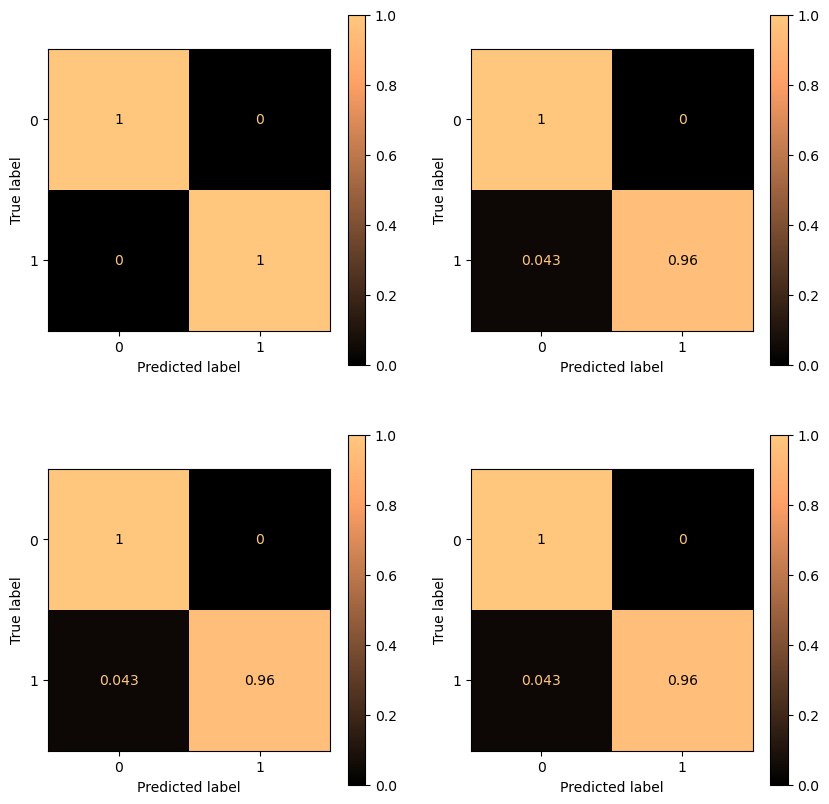

In [105]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# fig, ax = plt.subplots(figsize=(10, 10))
# cmp = ConfusionMatrixDisplay.from_predictions(np.arange(25), np.arange(25), ax=ax)

# Assign your existing figures to specific subplot positions
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred_nodes, y_true=y_true_nodes, normalize='true', cmap='copper', ax=axs[0, 0])  # Replace with your actual plotting code for fig1
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred_edges, y_true=y_true_edges, normalize='true', cmap='copper', ax=axs[0, 1])  # Replace with your actual plotting code for fig2
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred_edges, y_true=y_true_edges, normalize='true', cmap='copper', ax=axs[1, 0])  # Replace with your actual plotting code for fig3
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred_edges, y_true=y_true_edges, normalize='true', cmap='copper', ax=axs[1, 1])  # Replace with your actual plotting code for fig4

# Adjust the layout to ensure proper spacing between subplots
# plt.tight_layout()

# Show the combined plot
# plt.show()

sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay

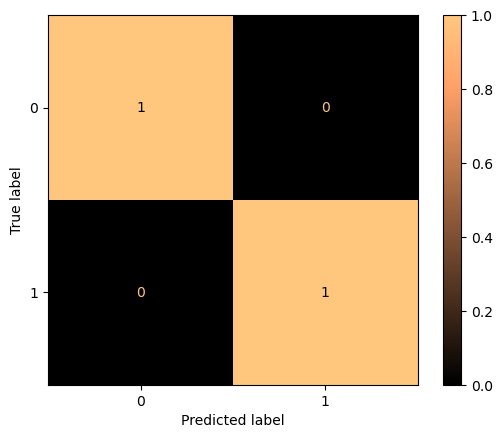

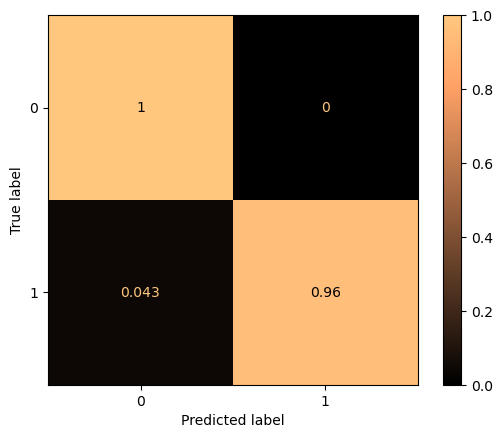

In [100]:
f1 = ConfusionMatrixDisplay.from_predictions(y_pred=y_pred_nodes, y_true=y_true_nodes, normalize='true', cmap='copper', xticks_rotation=0)
f2 = ConfusionMatrixDisplay.from_predictions(y_pred=y_pred_edges, y_true=y_true_edges, normalize='true', cmap='copper', xticks_rotation=0)
# plt.title("Hello")
# plt.show()
type(f1)

TypeError: Image data of dtype object cannot be converted to float

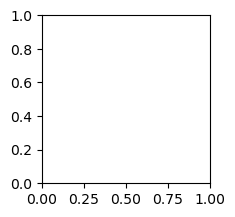

In [99]:
# Create a 2x2 grid of subplots
plt.subplot(2, 2, 1)
plt.imshow(f1)  # Replace with your actual plotting code

plt.subplot(2, 2, 2)
plt.imshow(f2)  # Replace with your actual plotting code

plt.subplot(2, 2, 3)
plt.imshow(f1)  # Replace with your actual plotting code

plt.subplot(2, 2, 4)
plt.imshow(f2)  # Replace with your actual plotting code

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()  # Show the combined plot


In [77]:
prf1_nodes = precision_recall_fscore_support(y_pred=y_pred_nodes, y_true=y_true_nodes)
prf1_nodes

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([104,  60]))

In [78]:
prf1_nodes = precision_recall_fscore_support(y_pred=y_pred_edges, y_true=y_true_edges)
prf1_nodes

(array([0.99537037, 1.        ]),
 array([1.        , 0.95652174]),
 array([0.99767981, 0.97777778]),
 array([430,  46]))

### *Semantic* vs. *instance* IoU calculation:

Intersection over union is calculated purely on the object level, therefore we can assume that the edge-specific information can be discarded at this point. 

*Note:* This entire method assumes that the object must form an edge, _i.e._ that an object cannot exist in isolation. This is an **assumption* we are making, not a universal truth. For example, when detecting roads in an image, it is unlikely that only a single local detection would correspond to a road. But this possibility cannot be excluded, for example if the road leads to a tunnel from one side and an airplane flew over it from the other side (2 different types of _object occlusion_). With our methodology, this isolated detection would not be considered a self-standing object. 

*Note:* Area under curve (AUC) metric is not applicable here, because the optimisation step 'strips off' the probabilities of predictions - all decisions here, _i.e._ to accept or reject a hypothesis of an existing node / edge, are of binary nature, all-or-nothing. The optimiser doesn't think that an edge is accepted with a certain probability, it just accepts or rejects it and it's decision is final. I think...

*Note:* METHOD LIMITATIONS: 
* relies on previous detections -> if an object is not detected(as in, is presented as a candidate node), it has no chance to appear in the final solution. This means:
  * we supply sparse but highly accurate detections must capture all objects (_e.g._ cryolo confidence threshold = 0.7)
  * we decrease the detection confidence threshold in belief that noisy detections will be filtered out by the classifier / optimiser (_e.g._ cryolo confidence threshold = 0.0)
  * we include all possible detections from the detection algorithm PLUS add some randomly picked positions just to make sure, making the same assumption as in the step before
* to avoid the limitation where we rely on an auxiliary particle picker, we could, in theory, sample a lot of random patches & let the pipeline just filter the clean / real nodes & links between them. This is a very romantic idea and I'm skeptical in claiming that this pipeline will "just figure itself out". But we don't know until we try... 
* our napari-based annotator GUI only provides an option to annotate objects _semantically_, _i.e._ with a single-valued brush, producing a binary mask. This could/should be addressed in later developments.

*Note to self:* We need to provide a (graphical) glossary / appendix where we describe the methodology / name the terms. Detection, object, graph, connection, instance, segment etc.


In [21]:
jaccard_score(y_true=y_true_nodes, y_pred=y_pred_nodes)


1.0

In [22]:
def intersection_over_union(set_1: set, set_2: set):

    # Calculate the intersection of sets
    intersection = len(set_1.intersection(set_2))

    # Calculate the union of sets
    union = len(set_1.union(set_2))

    if union < 1:
        return 0
    else:
        return intersection / union


### This is **SEMANTIC** object detection - all nodes pooled together:


In [111]:
sem = intersection_over_union(con_pool_pred_nodes, con_pool_true_nodes)
sem

1.0

### This is **INSTANCE** object detection: objects evaluated per identity:

In [24]:
def list_real_connected_components(graph: nx.Graph) -> list[set[int]]:
    """Filter through instance sets."""
    connected_comps = nx.connected_components(graph)
    con_comp_sets = []
    for comp in connected_comps:
        if len(comp) <= 1: continue
        con_comp_sets.append(comp)
    return con_comp_sets


In [25]:
# def map_nodes_to_sets(node_indices: list[int], con_comp_sets: list[set[int]]) -> dict[int, int]:
#     """Create a dictionary that maps nodes to sets."""
#     node_to_set = {}
#     for idx, node_set in enumerate(con_comp_sets):
#         for node in node_set:
#             node_to_set[node] = idx
#     return node_to_set


In [26]:
con_comp_sets_pred = list_real_connected_components(pred_graph)
con_comp_sets_true = list_real_connected_components(true_graph)

# node_indices = G.nodes(data=False)
# map_pred = map_nodes_to_sets(node_indices, con_comp_sets_pred)
# map_true = map_nodes_to_sets(node_indices, con_comp_sets_true)

# map_pred, map_true

In [27]:
# # Iterate through the list of nodes and find the set each node belongs to

# node_dict = {n : None for n in node_indices}
# iou_list = []

# for node_idx in node_indices:
#     if node_idx not in map_pred and node_idx not in map_true:
#         # index present in no list, good!
#         continue
#     if node_idx not in map_pred and node_idx in map_true:
#         # underdetected node:
#         current_set = con_comp_sets_true[map_true[node_idx]]
#         print ("under", current_set)
#     if node_idx in map_pred and node_idx not in map_true:
#         # overdetected node:
#         current_set = con_comp_sets_pred[map_pred[node_idx]]
#         print ("over", current_set)
#     if node_idx in map_pred and node_idx in map_true:
#         # match! calculate iou!
#         set_pred = con_comp_sets_pred[map_pred[node_idx]]
#         set_true = con_comp_sets_true[map_true[node_idx]]
#         iou = intersection_over_union(set_pred, set_true)
#         print ("iou", iou)
#         iou_list.append(iou)

#     # node_set_index = map_pred.get(node_idx)

#     # if node_set_index is not None:
#     #     print(f"{node_idx} belongs to set {node_set_index}")
#     # else:
#     #     print(f"{node_idx} does not belong to any set")


In [28]:
def find_matching_pairs(list_of_sets1, list_of_sets2):
    matching_pairs = []
    for set1 in list_of_sets1:
        for set2 in list_of_sets2:
            if len(set1.intersection(set2)) > 0:
                matching_pairs.append((set1, set2))
    return matching_pairs


In [29]:
# Find matching pairs of sets with at least one common node
matching_pairs = find_matching_pairs(con_comp_sets_pred, con_comp_sets_true)

iou_list = []
for pair in matching_pairs:
    iou_score = intersection_over_union(pair[0], pair[1])
    print("Matching Pair:", pair)
    print("IoU Score:", iou_score)
    iou_list.append(iou_score)


Matching Pair: ({100, 101, 102, 103}, {100, 101, 102, 103})
IoU Score: 1.0
Matching Pair: ({104, 105, 106, 107, 108, 109}, {104, 105, 106, 107, 108, 109})
IoU Score: 1.0
Matching Pair: ({112, 111}, {112, 111})
IoU Score: 1.0
Matching Pair: ({113, 114}, {113, 114})
IoU Score: 1.0
Matching Pair: ({115, 116, 117, 118}, {115, 116, 117, 118, 119, 120, 121})
IoU Score: 0.5714285714285714
Matching Pair: ({120, 121, 119}, {115, 116, 117, 118, 119, 120, 121})
IoU Score: 0.42857142857142855
Matching Pair: ({122, 123}, {122, 123})
IoU Score: 1.0
Matching Pair: ({128, 129, 130, 131, 124, 125, 126, 127}, {128, 129, 130, 131, 124, 125, 126, 127})
IoU Score: 1.0
Matching Pair: ({133, 134, 135, 136, 137, 138, 139, 140}, {133, 134, 135, 136, 137, 138, 139, 140})
IoU Score: 1.0
Matching Pair: ({141, 142, 143, 144, 145, 146, 147}, {141, 142, 143, 144, 145, 146, 147})
IoU Score: 1.0
Matching Pair: ({148, 149, 150, 151, 152}, {148, 149, 150, 151, 152})
IoU Score: 1.0
Matching Pair: ({153, 154, 155, 156, 15

# ^^^ Individual IoU scores per object:

Remember, the object needs to be evaluated multiple times it is if present (member of) multiple objects. 

### Visualisation ideas:
+ wrap up numerical table
+ Jaccard index histogram
+ bounding boxes (find outermost coords)
+ if object is in both graphs, green
+ if in pred only, yellow
+ if in true only, blue 
* etc..


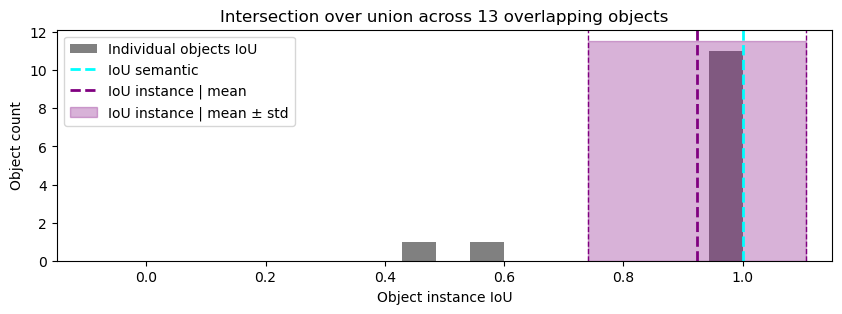

In [120]:
def plot_iou_histogram(iou_per_object: npt.NDArray, iou_semantic: float, figsize : tuple[int, int] = (10, 3)) -> None:
    
    plt.figure(figsize=figsize)

    plt.hist(iou_per_object, color='grey', label="Individual objects IoU")
    plt.xlim(-0.15, 1.15)
    mn, std = np.mean(iou_per_object), np.std(iou_per_object)
    
    # Add vertical lines
    plt.axvline(x=iou_semantic, color='cyan', linestyle='dashed', linewidth=2, label='IoU semantic')
    plt.axvline(x=mn, color='purple', linestyle='dashed', linewidth=2, label='IoU instance | mean')
    plt.axvline(x=mn-std, color='purple', linestyle='dashed', linewidth=1)
    plt.axvline(x=mn+std, color='purple', linestyle='dashed', linewidth=1)

    # Fill the area between the vertical lines
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mn-std, mn+std, color='purple', alpha=0.3, label='IoU instance | mean ± std')

    plt.xlabel("Object instance IoU")
    plt.ylabel("Object count")
    plt.title(f"Intersection over union across {len(iou_per_object)} overlapping objects")
    plt.legend()
    plt.show()
    plt.close()


plot_iou_histogram(iou_list, iou_semantic=sem)

### Colour-code the graph:

In [31]:
matching_pairs

[({100, 101, 102, 103}, {100, 101, 102, 103}),
 ({104, 105, 106, 107, 108, 109}, {104, 105, 106, 107, 108, 109}),
 ({111, 112}, {111, 112}),
 ({113, 114}, {113, 114}),
 ({115, 116, 117, 118}, {115, 116, 117, 118, 119, 120, 121}),
 ({119, 120, 121}, {115, 116, 117, 118, 119, 120, 121}),
 ({122, 123}, {122, 123}),
 ({124, 125, 126, 127, 128, 129, 130, 131},
  {124, 125, 126, 127, 128, 129, 130, 131}),
 ({133, 134, 135, 136, 137, 138, 139, 140},
  {133, 134, 135, 136, 137, 138, 139, 140}),
 ({141, 142, 143, 144, 145, 146, 147}, {141, 142, 143, 144, 145, 146, 147}),
 ({148, 149, 150, 151, 152}, {148, 149, 150, 151, 152}),
 ({153, 154, 155, 156, 157, 158}, {153, 154, 155, 156, 157, 158}),
 ({159, 160, 161}, {159, 160, 161})]

In [32]:
def locate_rectangle_points(object_node_set: set, G: nx.Graph):

    nodes = G.nodes(data=True)
    x_coords, y_coords = [], []
    
    for node_idx in object_node_set:
        y_coords.append(nodes[node_idx][GraphAttrs.NODE_Y])
        x_coords.append(nodes[node_idx][GraphAttrs.NODE_X])
    
    x_mn, x_mx = np.min(x_coords), np.max(x_coords) 
    y_mn, y_mx = np.min(y_coords), np.max(y_coords)

    return (x_mn, y_mn), x_mx-x_mn, y_mx-y_mn  # anchor, height, width
    

In [37]:
rectangles = []
color_list = ['limegreen', 'gold', 'dodgerblue']
legend_handle = {
    'limegreen' : 'perfect match', 
    'gold' : 'only in predicted graph', 
    'dodgerblue' : 'only in ground truth',
}

for pair in matching_pairs:
    
    # Check if objects are equal: 
    if pair[0] == pair[1]:
        anchor, height, width = locate_rectangle_points(pair[0], G)
        rectangles.append((anchor, height, width, color_list[0]))
    
    else:
        # Unwrap both & store rectangle coords + correct colour:
        for o, obj in enumerate(pair):
            anchor, height, width = locate_rectangle_points(pair[o], G)
            rectangles.append((anchor, height, width, color_list[o+1]))


In [38]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))


In [39]:
def visualise_object_bounding_boxes_on_graph(G: nx.Graph, rectangles: list[tuple[float]], legend_handle: dict[str, str], figsize: tuple[int] = (10, 10)) -> None:
    """TODO: Fill in."""
    # Create figure and axes
    _, ax = plt.subplots(figsize=figsize)

    # Display the graph node positions
    pos = {
        idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y])
        for idx, node in G.nodes(data=True)
    }

    # draw all nodes/vertices in the graph
    nx.draw_networkx(
        G, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32
    )

    # plot the rectangles one by one
    for rectangle in rectangles:
        anchor, height, width, color = rectangle
        handle = legend_handle[color]
        rect = patches.Rectangle(anchor, height, width, label=handle,
            linewidth=3, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        legend_without_duplicate_labels(ax)

    ax.set_title("IoU metric illustration on per-object level")
    plt.show()


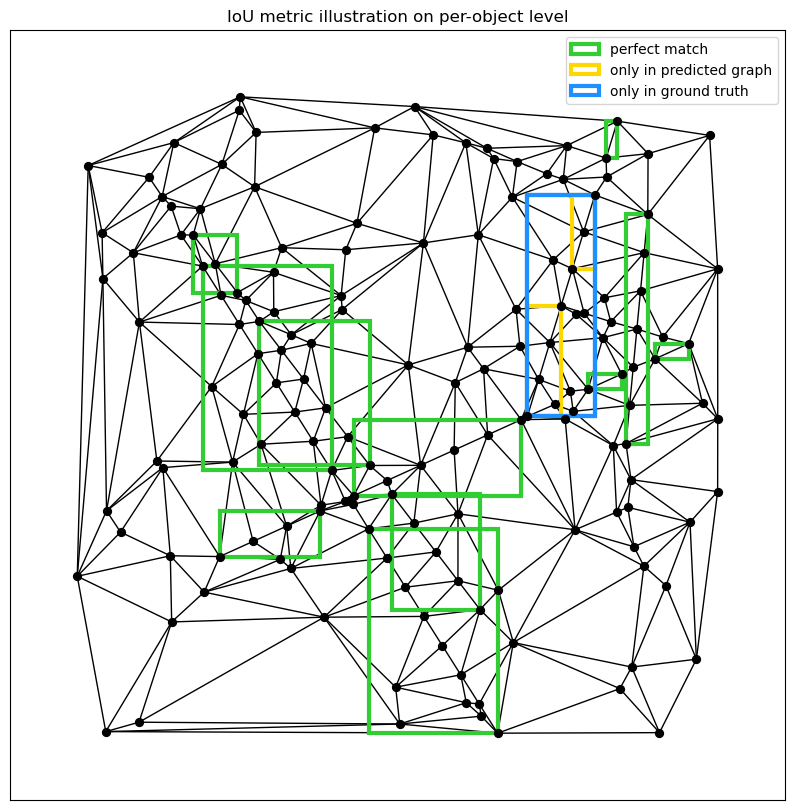

In [40]:
visualise_object_bounding_boxes_on_graph(G, rectangles, legend_handle)

## Proof of concept - adding / removing random edges & recalculating exact metrics:

1. randomly add some edges
2. randomly remove some edges
3. randomly add & remove some edges


In [47]:
def add_random_edges(G: nx.Graph, num_edges_to_add: int) -> nx.Graph:
    nodes = list(G.nodes())
    node_pairs = np.random.choice(nodes, size=(num_edges_to_add, 2), replace=True)
    
    for node1, node2 in node_pairs:
        if not G.has_edge(node1, node2) and node1 != node2:
            G.add_edge(node1, node2)
    return G

def remove_random_edges(G: nx.Graph, num_edges_to_remove: int) -> nx.Graph:
    edges = list(G.edges())
    edges_to_remove = np.random.choice(edges, size=num_edges_to_remove, replace=False)
    G.remove_edges_from(edges_to_remove)
    return G

def add_and_remove_random_edges(
    G: nx.Graph, 
    num_edges_to_add: int, 
    num_edges_to_remove: int
) -> nx.Graph:
    """Adds random edges and removes random edges from the given graph.

    Parameters
    ----------
    graph : nx.Graph
        The input graph.
    num_edges_to_add : int
        The number of random edges to add.
    num_edges_to_remove : int
        The number of random edges to remove.

    Returns
    -------
        nx.Graph: The graph with added and removed random edges.
    """
    if num_edges_to_add < 1:
        modified_graph = G.copy()
    else:
        modified_graph = add_random_edges(G.copy(), num_edges_to_add)

    if num_edges_to_remove < 1:
        return modified_graph
    else:
        return remove_random_edges(modified_graph, num_edges_to_remove)
        

## Randomly adding some edges

In [49]:
graph_new_edges = add_and_remove_random_edges(pred_graph, num_edges_to_add=5, num_edges_to_remove=0)
pred_graph.number_of_edges(), graph_new_edges.number_of_edges()

(47, 52)

## Randomly removing some edges

## Randomly adding & removing some edges

In [59]:
def format_object_detection_metrics(
    metrics_dict: dict[str, float], 
    title: str = "Object detection metrics", 
    minimum_padding: int = 0
) -> str:
    # Calculate the maximum length of metric names for formatting
    max_metric_length = max(len(metric) for metric in metrics_dict.keys())

    # Calculate the total width of the table (including borders)
    min_table_width = max(max_metric_length + minimum_padding * 2, len(title) + minimum_padding * 2)

    # Construct the table as a multiline string
    formatted_table = []
    formatted_table.append("=" * min_table_width)
    title_str = title[:min_table_width - minimum_padding * 2].center(min_table_width)
    formatted_table.append(title_str)
    formatted_table.append("=" * min_table_width)
    for metric, value in metrics_dict.items():
        formatted_table.append(f"{metric:{max_metric_length}} : {value:.2f}")
    formatted_table.append("=" * min_table_width)
    
    return '\n'.join(formatted_table)

# Your dictionary of object detection metrics
object_detection_metrics = {
    "Precision": 0.85,
    "Recall": 0.92,
    "F1 Score": 0.88,
    "Accuracy": 0.87
    # Add more metrics here
}

# Format the table
formatted_table = format_object_detection_metrics(object_detection_metrics)

# Print the formatted table
print(formatted_table)


Object detection metrics
Precision : 0.85
Recall    : 0.92
F1 Score  : 0.88
Accuracy  : 0.87


In [60]:
def combine_multiline_strings(string1, string2):
    lines1 = string1.split('\n')
    lines2 = string2.split('\n')
    combined_lines = [f"{line1:<50} {line2}" for line1, line2 in zip(lines1, lines2)]
    combined_string = '\n'.join(combined_lines)
    return combined_string

# Two multiline strings with metrics
string1 = """
Object detection metrics
=======================
Precision : 0.85
Recall    : 0.92
F1 Score  : 0.88
Accuracy  : 0.87
"""

string2 = """
Object classification metrics
=============================
Accuracy : 0.78
Precision: 0.72
Recall   : 0.82
F1 Score : 0.77
"""

# Combine the multiline strings into two columns
combined_table = combine_multiline_strings(string1, string2)

# Print the combined table
print(combined_table)


                                                   
Object detection metrics                           Object classification metrics
=======================                            =============================
Precision : 0.85                                   Accuracy : 0.78
Recall    : 0.92                                   Precision: 0.72
F1 Score  : 0.88                                   Recall   : 0.82
Accuracy  : 0.87                                   F1 Score : 0.77
                                                   


In [73]:
def combine_multiline_strings(string1, string2, column_gap=10):
    lines1 = string1.split('\n')
    lines2 = string2.split('\n')
    assert len(lines1) == len(lines2)
    
    max_line_length = max(len(line) for line in lines1)
    combined_lines = [f"{line1:<{max_line_length+column_gap}}{line2}" for line1, line2 in zip(lines1, lines2)]
    combined_string = '\n'.join(combined_lines)
    return combined_string

# Two multiline strings with metrics
string1 = """
Object detection metrics
=======================
Precision : 0.85
Recall    : 0.92
F1 Score  : 0.88
Accuracy  : 0.87
"""

string2 = """
Object classification metrics
=============================
Accuracy : 0.78
Precision: 0.72
Recall   : 0.82
F1 Score : 0.77
"""

# Combine the multiline strings into two columns with a custom column gap
combined_table = combine_multiline_strings(string1, string2, column_gap=5)

# Print the combined table
print(combined_table)


                             
Object detection metrics     Object classification metrics
=======================      =============================
Precision : 0.85             Accuracy : 0.78
Recall    : 0.92             Precision: 0.72
F1 Score  : 0.88             Recall   : 0.82
Accuracy  : 0.87             F1 Score : 0.77
                             


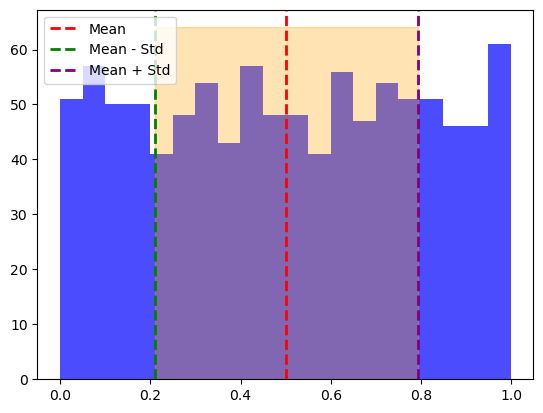

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# Generate example data for the histogram
data = np.random.rand(1000)

# Calculate mean and standard deviation
mean = np.mean(data)
std = np.std(data)

# Create the histogram
plt.hist(data, bins=20, alpha=0.7, color='blue')

# Set the x-limits for the vertical lines
x_min = mean - std
x_max = mean + std

# Fill the area between the vertical lines
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], x_min, x_max, color='orange', alpha=0.3)

# Add vertical lines
plt.axvline(x=mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(x=x_min, color='green', linestyle='dashed', linewidth=2, label='Mean - Std')
plt.axvline(x=x_max, color='purple', linestyle='dashed', linewidth=2, label='Mean + Std')

# Add legend
plt.legend()

# Show the plot
plt.show()
